# GPT 4 Experiments

In [1]:
from pprint import pprint
from typing import Dict, List
import numpy as np
from tqdm import tqdm

from nxontology_ml.data import read_training_data, get_efo_otar_slim
from nxontology_ml.gpt_tagger import TaskConfig, GptTagger
from nxontology_ml.utils import ROOT_DIR
from experimentation.model_utils import mean_absolute_error, one_h_enc

In [2]:
##
# Fetch node labels using GPT-4
N_SAMPLES = 500
CHOICES = 3
CLASS_MAP: Dict[str, int] = {
    "high": 0,  # "01-disease-subtype"
    "medium": 1,  # "02-disease-root"
    "low": 2,  # "03-disease-area"
}

# Create a config for EFO nodes labelling
config = TaskConfig(
    name="precision",
    prompt_path=ROOT_DIR / "prompts/precision_v1.txt",
    openai_model_name="gpt-4",
    node_attributes=["efo_id", "efo_label", "efo_definition"],
    model_n=CHOICES,
    prompt_token_ratio=0.5,
)

# Get a few EFO nodes
X, y = read_training_data(take=N_SAMPLES, filter_out_non_disease=True)
nxo = get_efo_otar_slim()
nodes = [nxo.node_info(node) for node in X]

# Get their labels
tagger = GptTagger.from_config(config)
labeled_nodes = []
for ln in tqdm(
    tagger.fetch_labels(nodes),
    total=len(X),
    desc="Fetching node tags using GPT-4",
    ncols=100,
):
    labeled_nodes.append(ln)

# Inspect metrics
print("\nTagger metrics:")
pprint(tagger.get_metrics())

Fetching node tags using GPT-4: 100%|███████████████████████████| 500/500 [00:00<00:00, 4365.37it/s]


Tagger metrics:
Counter({'Cache/get': 500, 'Cache/hits': 500})


In [3]:
##
# Manually remove corrupt nodes from the cache

from nxontology_ml.gpt_tagger._cache import _Cache
from nxontology_ml.gpt_tagger._utils import node_to_str_fn
from time import sleep


def delete_node_from_gpt_cache(node_id: str) -> None:
    node = nxo.node_info(node_id)
    cache_key = node_to_str_fn(config)(node)
    print(f"Deleting {node_id} from cache")
    cache = _Cache.from_config(config)
    assert cache.get(cache_key), f"Key not found in cache:\n{cache_key}"
    del cache[cache_key]


# delete_node_from_gpt_cache(node_id="EFO:0004191")  # labels were: ['NA', 'medium', 'medium']
# delete_node_from_gpt_cache(node_id="MONDO:0700070")  # (for node: node.identifier='MONDO:0700070'; ln.labels=['high', 'high', 'high', 'high', 'high', 'high', 'high', 'high+xml'])

In [4]:
##
# Map labeled nodes into probabilities

y_probas: List[np.array] = []
for node, ln in zip(nodes, labeled_nodes):
    assert node.identifier == ln.node_efo_id, f"{node.identifier} != {ln.node_efo_id}"
    w = np.zeros(len(CLASS_MAP), dtype=np.float32)
    for label in ln.labels:
        try:
            w[CLASS_MAP[label.lower()]] += 1.0 / CHOICES
        except KeyError as e:
            print(f"Wrong key: {label} (for node: {node.identifier=}; {ln.labels=})")
            raise e
    y_probas.append(w)

# Biased MAE
y_true = np.array([one_h_enc[l] for l in y])
print(
    f"(Label counts as probas) BiasedMAE: {mean_absolute_error(y_true, np.array(y_probas)):.3f}"
)

(Label counts as probas) BiasedMAE: 0.267


In [5]:
##
# Find most common label for each node

from collections import Counter

y_probas: List[np.array] = []
for node, ln in zip(nodes, labeled_nodes):
    assert node.identifier == ln.node_efo_id, f"{node.identifier} != {ln.node_efo_id}"
    w = np.zeros(len(CLASS_MAP), dtype=np.float32)
    c = Counter(ln.labels)
    w[CLASS_MAP[c.most_common(1)[0][0].lower()]] = 1.0
    y_probas.append(w)

# Biased MAE
y_true = np.array([one_h_enc[l] for l in y])
print(
    f"(Most common label) BiasedMAE: {mean_absolute_error(y_true, np.array(y_probas)):.3f}"
)

(Most common label) BiasedMAE: 0.261


In [6]:
##
# Metrics on tags
import json

labels_cnt = Counter()
for key, val in tagger._cache._storage:
    labels = json.loads(val)
    assert len(labels) == 3
    labels_cnt.update(labels)

print(
    f"GPT-4 labels proportion:\n\t{', '.join(f'{k}={v/N_SAMPLES/3:.2f}' for k, v in labels_cnt.most_common())}"
)
print(
    f"Samples (true) labels proportion:\n\t{', '.join(f'{k}={v/N_SAMPLES:.2f}' for k, v in Counter(y).most_common())}"
)

GPT-4 labels proportion:
	high=0.47, medium=0.36, low=0.17
Samples (true) labels proportion:
	01-disease-subtype=0.51, 02-disease-root=0.38, 03-disease-area=0.11


# "Old-School" ML Experiments

## Experiments

Each "experiment" consists in a set of identical models, trained on different folds of data (with both consistent model and features parameters).

(Reason: The metrics for each model tend to vary a little, so training them on many folds enables a more accurate comparison across models/features)

## Metrics

The main metrics tracked are:
- Biased MAE (from [#9](https://github.com/related-sciences/nxontology-ml/issues/9))
- The class "Biases" (also [#9](https://github.com/related-sciences/nxontology-ml/issues/9)) are:
```python
biases = {
    "01-disease-subtype": 0.25,
    "02-disease-root": 0.25,
    "03-disease-area": 0.5,
}
```
- For both training and cv sets: ROC, F1 & model Loss ([CatBoost's `MultiClass`](https://catboost.ai/en/docs/concepts/loss-functions-multiclassification))

## Parameters

Constant parameters across each experiment (currently):
- Shuffled inputs
- 25 folds stratified CV
- Best model is selected (based on BiasedMAE)
- 5000 training iterations
- Learning rate of 0.5

# Loading Experiments Data

In [7]:
%load_ext autoreload
%autoreload 2

from experimentation.metadata_helpers import (
    df_from_all_experiments,
    NUMERICAL_COLUMNS,
    EXPERIMENT_MODEL_DIR,
)
from typing import List
import pandas as pd
import seaborn as sns

sns.set_theme()

In [8]:
df = df_from_all_experiments()

# Sort by median BiasedMAE
experiment_median_mae = df.groupby("experiment_name")["biased_mae"].median().to_dict()
df = df.sort_values(
    by="experiment_name", key=lambda e: e.apply(experiment_median_mae.get)
)

# Experiments by Biased MAEs

In [9]:
import warnings

# Since updating Pandas, seaborn is throwing a lot of pandas FutureWarning :(
warnings.simplefilter(action="ignore", category=FutureWarning)

<Axes: xlabel='biased_mae', ylabel='experiment_name'>

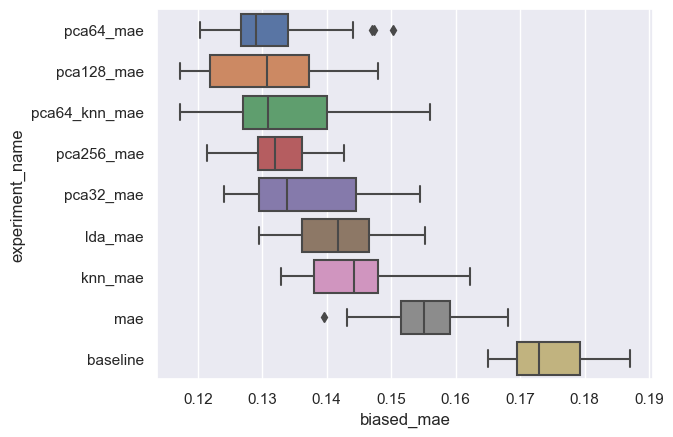

In [10]:
sns.boxplot(data=df, x="biased_mae", y="experiment_name")

Notes about experiments:
- `baseline`: (Mostly) default parameters for network only features (as presented in [#7](https://github.com/related-sciences/nxontology-ml/pull/7))
- `mae`: Uses the (custom coded) `BiasedMAE` metric as [CatBoost's custom `eval_metric`](https://catboost.ai/en/docs/concepts/python-usages-examples#custom-loss-function-eval-metric)
- `d7`: CatBoost tree depth of 7 (default is 6) - although not obvious here, `d=7` usually helps when using more features
- `knn`: Use Faiss NN tree proximity features
- `lda`: 3 Class LDA for dimensionality reduction
- `pcaX`: PCA of `X` components for dimensionality reduction

For MAE comparison: 
- A random classifier with real class weights prior has a biased MAE of `0.340`
- A random classifier with uniform class weights prior has a biased MAE of `0.426`

# Top experiment (`pca128_d7_mae`) analysis

## CatBoost's `MetricVisualizer`

In [11]:
import catboost

experiment_dir = EXPERIMENT_MODEL_DIR / "20230908_031209_pca64_mae"
w = catboost.MetricVisualizer(experiment_dir.as_posix(), subdirs=True)
w.start()

# Notes:
# - This visualization runs JavaScript and won't be displayed on the web
# - The experiment data is needed locally for this code to render

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Metrics Cross-Analysis

/Users/romain/dev/nxontology-ml/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


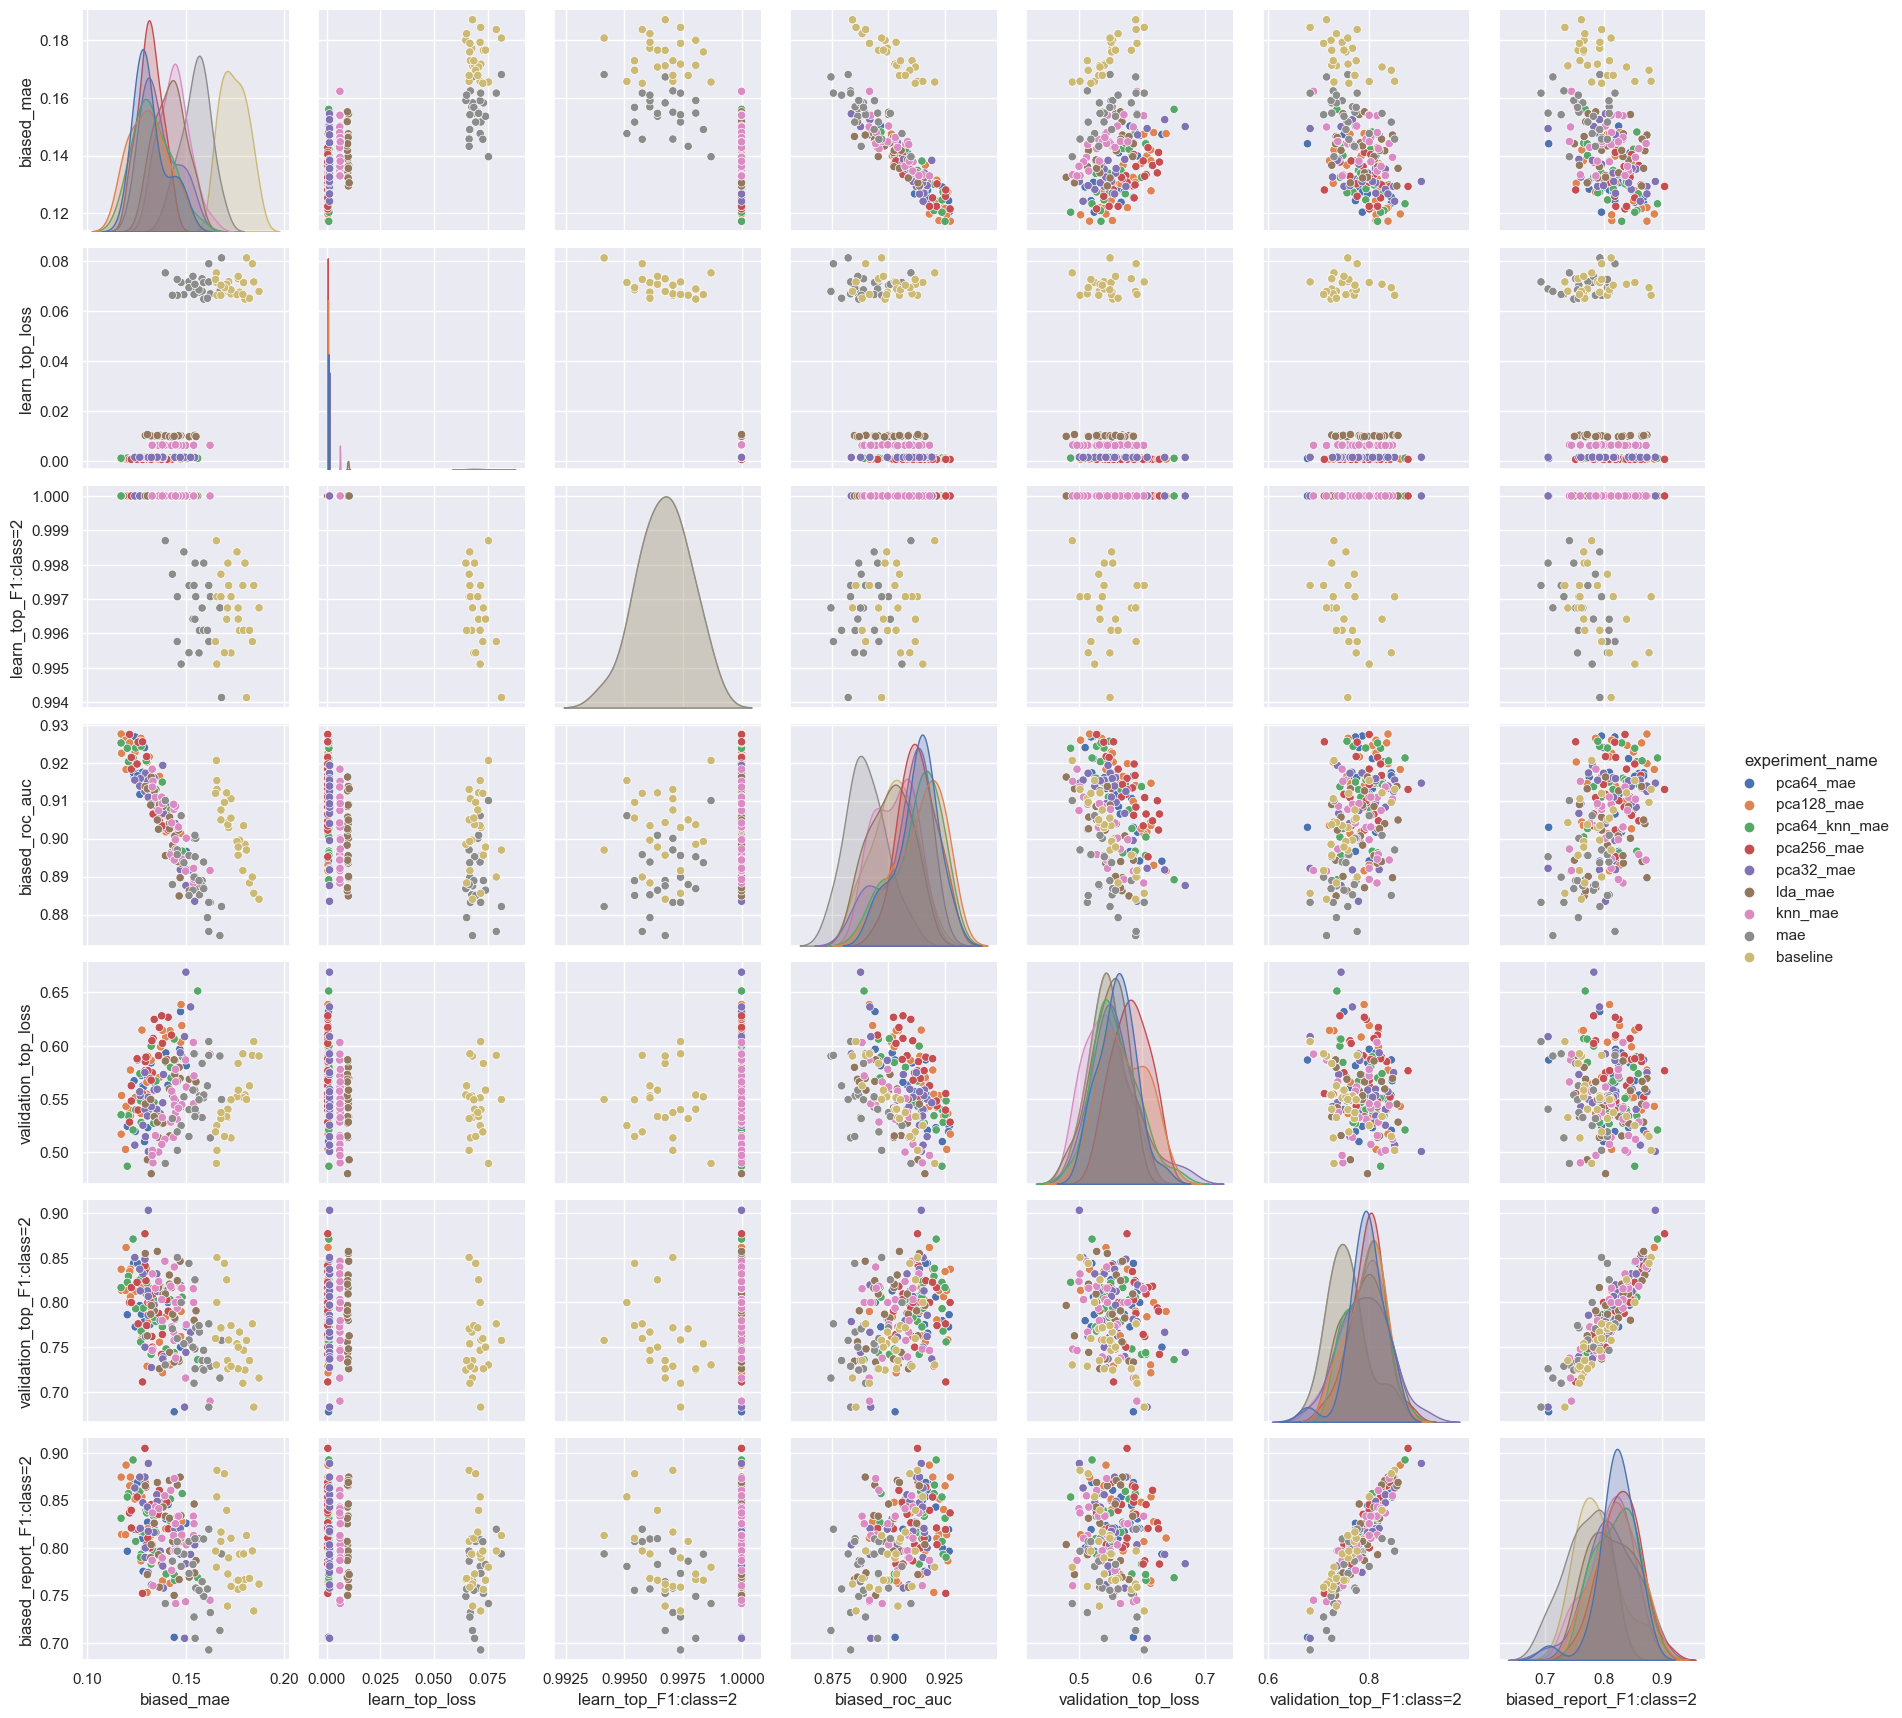

In [12]:
excluded_columns = {
    "roc_auc",  # Correlation with biased_roc_auc
    "validation_top_AUC:type=Mu",  # Correlation with biased_roc_auc
    "report_F1:class=2",  # Correlation with biased_report_F1:class=2
    "mae",  # Correlation with biased_mae
}
columns = list({"experiment_name"} | (set(NUMERICAL_COLUMNS) - excluded_columns))
sns.pairplot(df[columns], hue="experiment_name")

Notes:
- `learn_`: Computed by Catboost during training
- `validation_`: Computed by Catboost during CV
- `report_`: From SKLearn's Classifier report

# Experiment Training Durations

In [13]:
df.head()

,experiment_name,experiment_description,fold,start_time,report_F1:class=2,biased_report_F1:class=2,roc_auc,biased_roc_auc,mae,biased_mae,learn_loss,learn_top_loss,learn_top_F1:class=2,validation_top_loss,validation_top_AUC:type=Mu,validation_top_F1:class=2,tree_cnt,feature_building_d,training_d,eval_d
62,pca64_mae,pca64_mae,9,2023-09-08 03:12:09.701725,0.836066,0.860759,0.912173,0.917167,0.189522,0.125857,MultiClass,0.000905,1.0,0.553844,0.942672,0.842975,5000,0 days 00:00:10.486744,0 days 00:02:02.617389,0 days 00:00:00.046467
52,pca64_mae,pca64_mae,2,2023-09-08 03:12:09.701725,0.744186,0.793388,0.890020,0.894074,0.213636,0.147299,MultiClass,0.000908,1.0,0.632056,0.925762,0.750000,5000,0 days 00:00:09.265000,0 days 00:01:40.459878,0 days 00:00:00.027733
53,pca64_mae,pca64_mae,5,2023-09-08 03:12:09.701725,0.822581,0.853556,0.911556,0.916426,0.183588,0.123782,MultiClass,0.000899,1.0,0.567236,0.947106,0.845528,5000,0 days 00:00:09.902515,0 days 00:01:49.283525,0 days 00:00:00.043620
54,pca64_mae,pca64_mae,19,2023-09-08 03:12:09.701725,0.800000,0.845528,0.902511,0.908403,0.207115,0.140963,MultiClass,0.000918,1.0,0.563169,0.938760,0.800000,5000,0 days 00:00:10.306572,0 days 00:01:50.654228,0 days 00:00:00.042476
55,pca64_mae,pca64_mae,21,2023-09-08 03:12:09.701725,0.769231,0.796460,0.925751,0.927016,0.174643,0.120344,MultiClass,0.000893,1.0,0.524525,0.948821,0.786325,5000,0 days 00:00:10.386793,0 days 00:01:52.247342,0 days 00:00:00.044353


/Users/romain/dev/nxontology-ml/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


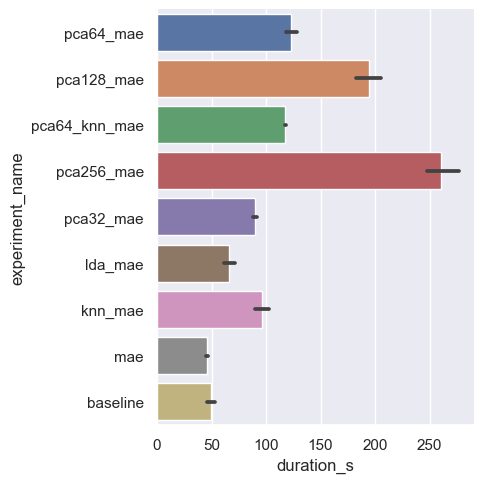

In [14]:
df["duration_s"] = (df["feature_building_d"] + df["training_d"]).dt.total_seconds()
sns.catplot(data=df, kind="bar", x="duration_s", y="experiment_name")

Notes:
- These duration are in seconds, per fold

# Experiment number of iterations

/Users/romain/dev/nxontology-ml/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


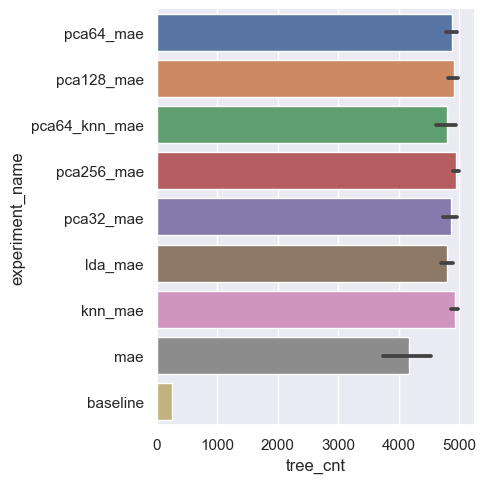

In [15]:
sns.catplot(
    data=df,
    x="tree_cnt",
    y="experiment_name",
    kind="bar",
)

Notes:
- For the models nearing `5000`, a little more performance could be gained by raising the number of max iterations

# MAE Baselines

In [16]:
import numpy as np
from experimentation.model_utils import CLASS_WEIGHTS, mean_absolute_error


def mae_baseline(class_weights: np.ndarray) -> float:
    biased_mae = 0
    for i, w_i in enumerate(CLASS_WEIGHTS):
        for j, w_j in enumerate(class_weights):
            y_true = np.zeros(len(CLASS_WEIGHTS))
            y_true[i] = 1
            y = np.zeros(len(CLASS_WEIGHTS))
            y[j] = 1
            biased_mae += (
                w_i * w_j * mean_absolute_error(np.array([y_true]), np.array([y]))
            )  # Biased by default
    return biased_mae


print(f"Baseline MAE (with weighted class prior): {mae_baseline(CLASS_WEIGHTS):.3f}")
print(
    f"Baseline MAE (with uniform class prior): {mae_baseline(np.array([1/3, 1/3, 1/3])):.3f}"
)

Baseline MAE (with weighted class prior): 0.340
Baseline MAE (with uniform class prior): 0.426


In [17]:
# Empirical check
N = 100000
print(
    mean_absolute_error(
        y_true=np.array([np.random.multinomial(1, CLASS_WEIGHTS) for _ in range(N)]),
        y_probas=np.array([np.random.multinomial(1, CLASS_WEIGHTS) for _ in range(N)]),
    )
)

0.3393575


# Some Conclusions (mostly from past experiments)
* Having a custom eval metric is very important
* More iterations is good
* LR declines over 1 (Sweet spot ~.5) - TODO: Add proof
* GPUs do not support custom eval
* Adding weights to samples does not help - TODO: Add proof
* (Depth helps but makes training slower - TODO: Add better proof)

# Possible Next steps
* Add GPT 4 label to features
* Node error analysis:
  1. Find nodes where the biggest mistakes are made 
  2. Try to come up with pattern in data (& features)
  3. Craft useful features if possible
* (Add feature importances to this report?)